In [1]:
# Data Reference Classifier for Make Data Count Competition

import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
from nltk.tokenize import sent_tokenize

In [2]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

# === Step 1: Load Dataset ===
data_dir = Path("D:/Jupyter_File/DML_Kelompok-B/Dataset")
train_labels = pd.read_csv(data_dir / "train_labels.csv")
sample_submission = pd.read_csv(data_dir / "sample_submission.csv")
train_xml_dir = data_dir / "train/XML"
test_xml_dir = data_dir / "test/XML"

[nltk_data] Downloading package stopwords to C:\Users\Nugroho
[nltk_data]     Agung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Nugroho
[nltk_data]     Agung\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [3]:
# Ekstrak teks dari XML
def extract_text_from_xml(xml_path):
    with open(xml_path, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f, 'xml')
    body = soup.find('body')
    return body.get_text(separator=' ', strip=True) if body else ""

In [4]:
# Preprocessing teks dasar
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9 ]', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

In [5]:
# Bangun dataset berdasarkan article_id dan label type
samples = []
for _, row in train_labels.iterrows():
    article_id = row['article_id']
    label = row['type'].lower()
    if label not in ['primary', 'secondary']:
        continue  
    xml_file = train_xml_dir / f"{article_id}.xml"
    if not xml_file.exists():
        continue
    text = extract_text_from_xml(xml_file)
    text = preprocess(text)
    samples.append((text, label))

train_df = pd.DataFrame(samples, columns=['text', 'label'])

In [6]:
# Train-test split dan pipeline TFIDF + Logistic Regression
X = train_df['text']
y = train_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

joblib.dump(model, data_dir / "model.joblib")

              precision    recall  f1-score   support

     primary       0.84      0.93      0.88        44
   secondary       0.96      0.91      0.93        85

    accuracy                           0.91       129
   macro avg       0.90      0.92      0.91       129
weighted avg       0.92      0.91      0.92       129



['D:\\Jupyter_File\\DML_Kelompok-B\\Dataset\\model.joblib']

In [7]:
import joblib
joblib.dump(model, "model.joblib")


['model.joblib']

In [8]:
# === Step 6: Inference on Test Set ===
test_predictions = []
model = joblib.load("model.joblib")

for xml_file in test_xml_dir.glob("*.xml"):
    doc_id = xml_file.stem
    full_text = extract_text_from_xml(xml_file)
    # Dummy chunking: sliding window (can be improved)
    chunk_size = 30
    stride = 15
    predictions = []
    for i in range(0, len(full_text) - chunk_size, stride):
        chunk = full_text[i:i+chunk_size]
        preprocessed = preprocess(chunk)
        if not preprocessed.strip():
            continue
        pred = model.predict([preprocessed])[0]
        predictions.append(f"{pred} {i} {i+chunk_size}")
    prediction_string = "|".join(predictions)
    test_predictions.append((doc_id, prediction_string))

submission_df = pd.DataFrame(test_predictions, columns=['Id', 'PredictionString'])
submission_df.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")


Submission saved as submission.csv


In [9]:
# Bandingkan performa beberapa model untuk klasifikasi kutipan data ilmiah

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings("ignore")

# Dataset
X = train_df['text']
y = train_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model yang akan dibandingkan
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Simpan hasil evaluasi
results = {}

for name, clf in models.items():
    print(f"\n===== {name} =====")
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000)),
        ('clf', clf)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True)
    results[name] = report
    print(classification_report(y_val, y_pred))



===== Logistic Regression =====
              precision    recall  f1-score   support

     primary       0.84      0.93      0.88        44
   secondary       0.96      0.91      0.93        85

    accuracy                           0.91       129
   macro avg       0.90      0.92      0.91       129
weighted avg       0.92      0.91      0.92       129


===== Random Forest =====
              precision    recall  f1-score   support

     primary       0.81      0.98      0.89        44
   secondary       0.99      0.88      0.93        85

    accuracy                           0.91       129
   macro avg       0.90      0.93      0.91       129
weighted avg       0.93      0.91      0.92       129



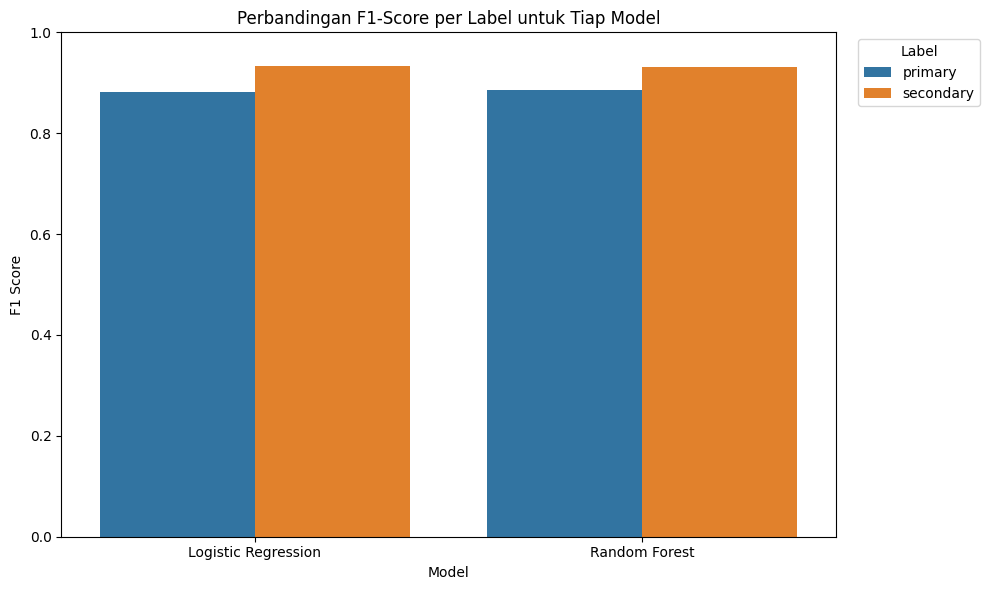

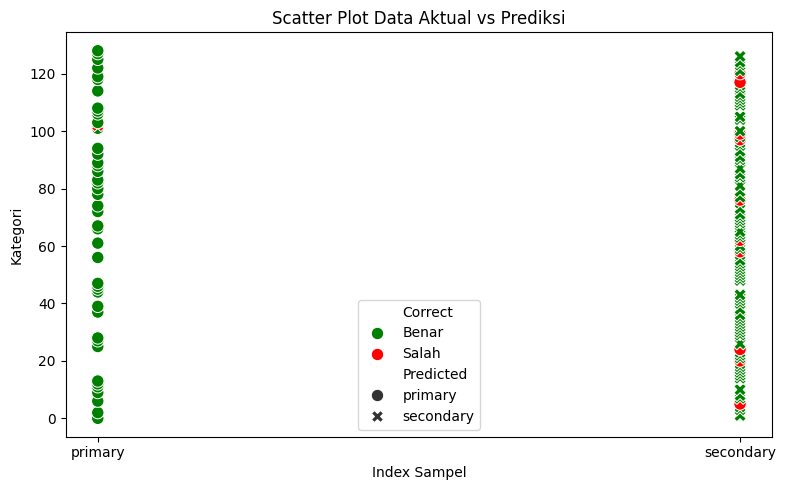

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ekstrak metrik f1-score untuk tiap label dari semua model
records = []
for model_name, metrics in results.items():
    for label in ['primary', 'secondary']:
        f1 = metrics[label]['f1-score']
        precision = metrics[label]['precision']
        recall = metrics[label]['recall']
        records.append({
            'Model': model_name,
            'Label': label,
            'F1-Score': f1,
            'Precision': precision,
            'Recall': recall
        })

# Konversi ke DataFrame
plot_df = pd.DataFrame(records)

# Visualisasi Bar Chart F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='Model', y='F1-Score', hue='Label')
plt.title('Perbandingan F1-Score per Label untuk Tiap Model')
plt.ylim(0, 1)
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.legend(title='Label', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

actual_vs_pred_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred
}).reset_index(drop=True)

# Beri warna berdasarkan status: cocok (True) atau tidak cocok (False)
actual_vs_pred_df['Correct'] = actual_vs_pred_df['Actual'] == actual_vs_pred_df['Predicted']
actual_vs_pred_df['Correct'] = actual_vs_pred_df['Correct'].map({True: 'Benar', False: 'Salah'})

plt.figure(figsize=(8, 5))
sns.scatterplot(data=actual_vs_pred_df,
                x='Actual',
                y=actual_vs_pred_df.index,
                hue='Correct',
                style='Predicted',
                palette={'Benar': 'green', 'Salah': 'red'},
                s=80)
plt.title('Scatter Plot Data Aktual vs Prediksi')
plt.xlabel('Index Sampel')
plt.ylabel('Kategori')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
